### Importing The Packages

In [ ]:
# Importing the libraries
!pip install vit-keras
!pip install tensorflow-addons
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, Input,Add, Dense, Dropout, Embedding, GlobalAveragePooling1D, Input, Layer, LayerNormalization, MultiHeadAttention
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50, MobileNetV3Large
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.utils import to_categorical
import warnings
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore")
import cv2
from tqdm import tqdm
from vit_keras import vit
import glob
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,classification_report,f1_score,ConfusionMatrixDisplay
import os
import pandas as pd

# if you don't have CUDA enabled gpu in your system comment the lines below
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 10.3 MB/s eta 0:00:00
Num GPUs Available:  1


### Mounting The Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#### unzip the dataset

# Define the path to the ZIP file and the target directory for extraction
zip_file_path = '/content/drive/MyDrive/dataset/data_set.zip'
extracted_folder_path = '/content/drive/MyDrive/dataset/'

# Use the ! command to unzip the file
!unzip "$zip_file_path" -d "$extracted_folder_path"

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/dataset/data_set/lung_image_sets/lung_n/lungn2010.jpeg  
  inflating: /content/drive/MyDrive/dataset/data_set/lung_image_sets/lung_n/lungn2014.jpeg  
  inflating: /content/drive/MyDrive/dataset/data_set/lung_image_sets/lung_n/lungn2015.jpeg  
  inflating: /content/drive/MyDrive/dataset/data_set/lung_image_sets/lung_n/lungn2016.jpeg  
  inflating: /content/drive/MyDrive/dataset/data_set/lung_image_sets/lung_n/lungn2018.jpeg  
  inflating: /content/drive/MyDrive/dataset/data_set/lung_image_sets/lung_n/lungn2019.jpeg  
  inflating: /content/drive/MyDrive/dataset/data_set/lung_image_sets/lung_n/lungn2022.jpeg  
  inflating: /content/drive/MyDrive/dataset/data_set/lung_image_sets/lung_n/lungn2024.jpeg  
  inflating: /content/drive/MyDrive/dataset/data_set/lung_image_sets/lung_n/lungn2025.jpeg  
  inflating: /content/drive/MyDrive/dataset/data_set/lung_image_sets/lung_n/lungn2028.jpeg  
  inflating: /conte

### Loading the dataset

In [ ]:
# loading the dataset
images = []
labels = []
# Location with subdirectories
path = "/content/drive/MyDrive/dataset/data_set"
# Get List of all images
files = glob.glob(path + '/**/*.jpeg', recursive=True)
# For each image
for file in  tqdm (files):
    img = cv2.imread(file)[:,:,::-1]
    img = cv2.resize(img,(224,224))
    #print(file)
    images.append(img)
    y = file.split('/')[-2]
    #print(y)
    labels.append(y)
images = np.array(images)
labels = np.array(labels)

100%|██████████| 9000/9000 [02:46<00:00, 54.07it/s]


### Data Analysis

In [ ]:
# shape of images
print("Shape of Data = ", images.shape)

Shape of Data =  (9000, 224, 224, 3)


In [ ]:
print("Shape of labels = ", labels.shape)

Shape of labels =  (9000,)


lung_aca    3000
lung_n      3000
lung_scc    3000
Name: labels, dtype: int64


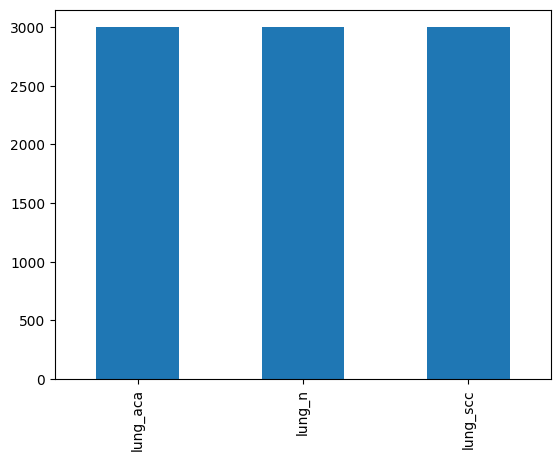

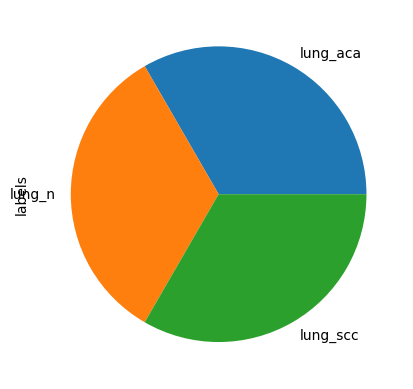

In [ ]:
# storing the labels in the data frame
labels_df = pd.DataFrame(labels,columns=['labels'])

print(labels_df['labels'].value_counts())
plt.figure()
labels_df['labels'].value_counts().plot.bar()
plt.show()
plt.figure()
labels_df['labels'].value_counts().plot.pie()
plt.show()

In [ ]:
# This code will help you in visualizing the images
#np.random.seed(42)
plt.figure(1 , figsize = (16 , 16))

for n in range(1, 17):
    plt.subplot(4, 4, n)
    index = int(np.random.randint(0, images.shape[0], 1))
    plt.title(str(labels[index]))
    plt.imshow(images[index])
    plt.axis('off')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# label encoding of categorical features
le = LabelEncoder()
labels = le.fit_transform(labels)

# one hot encoding to feed it into model
labels =to_categorical(labels)


In [ ]:
#### Splitting the data
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)


### Deep Learning Models


In [ ]:
class PlotLearning(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()

        self.logs = []

    def on_epoch_end(self, epoch, logs={}):

        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('accuracy'))
        self.val_acc.append(logs.get('val_accuracy'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)

        clear_output(wait=True)

        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.legend()

        ax2.plot(self.x, self.acc, label="accuracy")
        ax2.plot(self.x, self.val_acc, label="validation accuracy")
        ax2.legend()

        plt.show();

accuracy_loss_plot = PlotLearning()

### MobileNet V3

In [ ]:
### initializing the model
base_model = MobileNetV3Large(include_top= False, weights= "imagenet", input_shape= (224,224,3), pooling= 'max')
base_model.trainable = False
model = Sequential([
    base_model,
    Flatten(),
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    #Dropout(rate= 0.45, seed= 123),
    Dense(3, activation= 'softmax')
])
model.summary()

12683000/12683000 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Function  (None, 960)               2996352   
 al)                                                             
                                                                 
 flatten (Flatten)           (None, 960)               0         
                                                                 
 batch_normalization (Batch  (None, 960)               3840      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               246016    
                                                                 
 dense_1 (Dense)             (None, 3)                 771       
                                                         

In [ ]:
# compiling the model
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate= 0.001), metrics=['accuracy'])

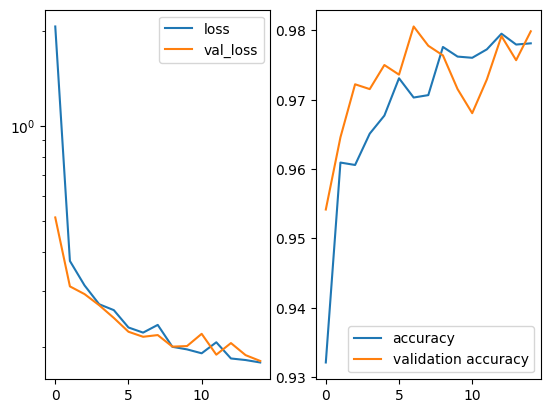

360/360 [==============================] - 4s 11ms/step - loss: 0.1780 - accuracy: 0.9781 - val_loss: 0.1800 - val_accuracy: 0.9799


In [ ]:
# train the model with min batch size as 32
history=model.fit(X_train,y_train,validation_split=0.2,epochs=15,batch_size=16, callbacks=accuracy_loss_plot)

#### Model Evaluation

In [ ]:
### train performace

In [ ]:
y_pred = model.predict(X_train,batch_size=16)
y_pred = np.argmax(y_pred,axis=-1)
y_true = np.argmax(y_train,axis=-1)

450/450 [==============================] - 4s 7ms/step


              precision    recall  f1-score   support

           0       0.98      0.99      0.99      2415
           1       1.00      1.00      1.00      2399
           2       0.99      0.98      0.99      2386

    accuracy                           0.99      7200
   macro avg       0.99      0.99      0.99      7200
weighted avg       0.99      0.99      0.99      7200



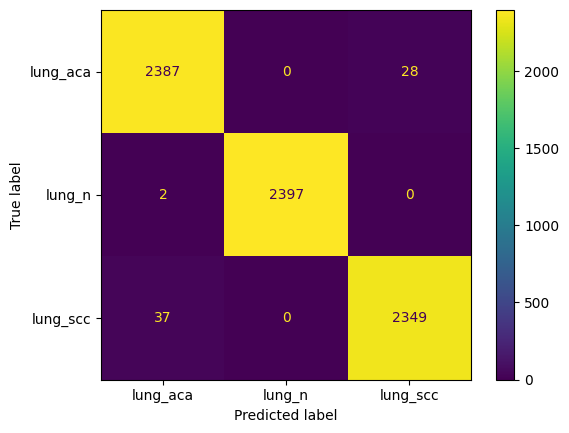

In [ ]:
# print # classification Report
print(classification_report(y_true,y_pred))
cm = confusion_matrix(y_true,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=list(le.classes_))
disp.plot()
plt.show()

In [ ]:
### test performace

In [ ]:
# get model predictions
y_pred = model.predict(X_test,batch_size=16)
y_pred = np.argmax(y_pred,axis=-1)
y_true = np.argmax(y_test,axis=-1)


113/113 [==============================] - 2s 12ms/step


              precision    recall  f1-score   support

           0       0.97      0.97      0.97       585
           1       1.00      1.00      1.00       601
           2       0.97      0.97      0.97       614

    accuracy                           0.98      1800
   macro avg       0.98      0.98      0.98      1800
weighted avg       0.98      0.98      0.98      1800



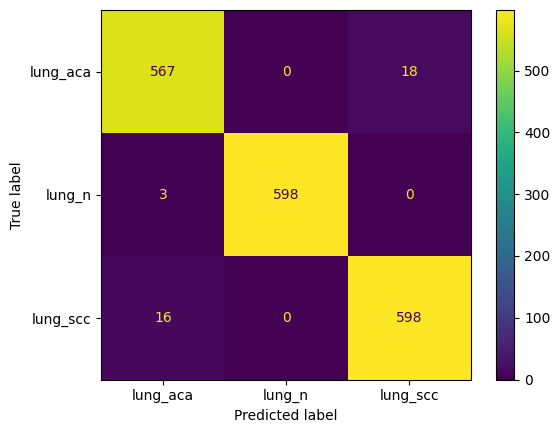

In [ ]:
# print # classification Report
print(classification_report(y_true,y_pred))
cm = confusion_matrix(y_true,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=list(le.classes_))
disp.plot()
plt.show()

In [ ]:
del(model)

### VGG 16

In [ ]:
### initializing the model
base_model = VGG16(include_top= False, weights= "imagenet", input_shape= (224,224,3), pooling= 'max')
base_model.trainable = False
model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(3, activation= 'softmax')
])

model.summary()

58889256/58889256 [==============================] - 2s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 batch_normalization_1 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 3)                 771       
                                                                 
Total params: 14848835 (56.64 MB)
Trainable params: 133

In [ ]:
### compiling the model
model.compile(Adam(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

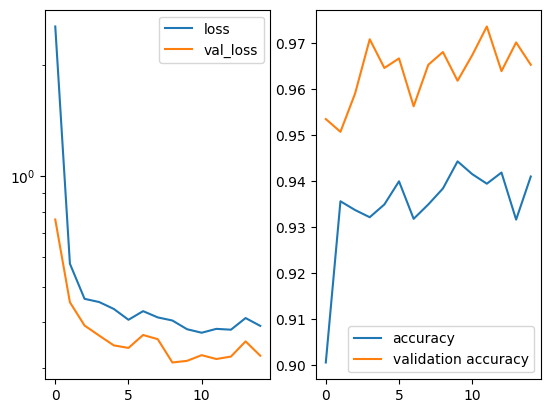

360/360 [==============================] - 9s 25ms/step - loss: 0.3912 - accuracy: 0.9410 - val_loss: 0.3246 - val_accuracy: 0.9653


In [ ]:
history=model.fit(X_train,y_train,batch_size=16,validation_split=0.2,epochs=15,callbacks=accuracy_loss_plot)

In [ ]:
### train performance

In [ ]:
y_pred = model.predict(X_train,batch_size=8)
y_pred = np.argmax(y_pred,axis=-1)
y_true = np.argmax(y_train,axis=-1)

900/900 [==============================] - 13s 13ms/step


              precision    recall  f1-score   support

           0       0.96      0.97      0.97      2415
           1       1.00      1.00      1.00      2399
           2       0.98      0.96      0.97      2386

    accuracy                           0.98      7200
   macro avg       0.98      0.98      0.98      7200
weighted avg       0.98      0.98      0.98      7200



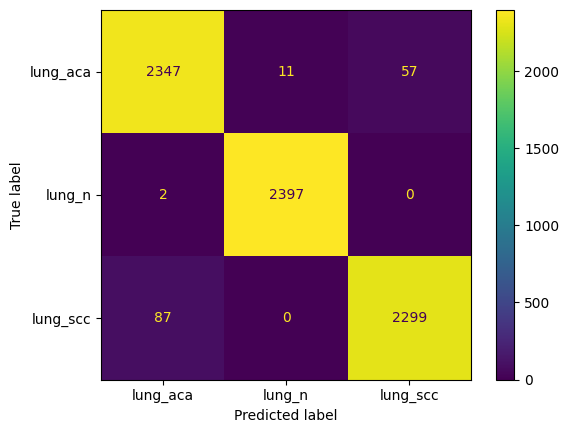

In [ ]:
# print # classification Report
print(classification_report(y_true,y_pred))
cm = confusion_matrix(y_true,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=list(le.classes_))
disp.plot()
plt.show()

In [ ]:
### test performance

In [ ]:
# get model predictions
y_pred = model.predict(X_test,batch_size=8)
y_pred = np.argmax(y_pred,axis=-1)
y_true = np.argmax(y_test,axis=-1)


225/225 [==============================] - 3s 13ms/step


              precision    recall  f1-score   support

           0       0.93      0.92      0.93       585
           1       0.99      1.00      0.99       601
           2       0.94      0.94      0.94       614

    accuracy                           0.95      1800
   macro avg       0.95      0.95      0.95      1800
weighted avg       0.95      0.95      0.95      1800



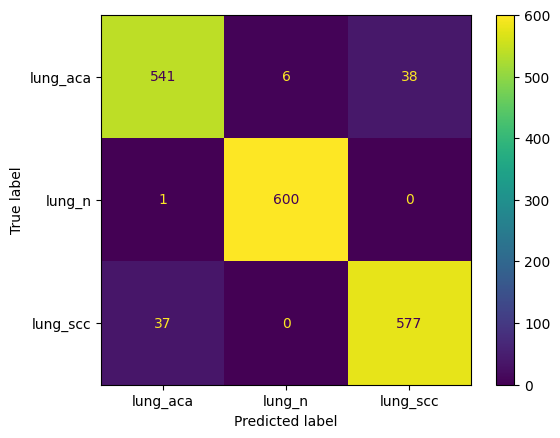

In [ ]:
# print # classification Report
print(classification_report(y_true,y_pred))
cm = confusion_matrix(y_true,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=list(le.classes_))
disp.plot()
plt.show()

In [ ]:
del(model)

### ResNet 50

In [ ]:
### initializing the model
base_model = ResNet50(include_top= False, weights= "imagenet", input_shape= (224,224,3), pooling= 'max')
base_model.trainable = False
model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(3, activation= 'softmax')
])

model.summary()

94765736/94765736 [==============================] - 3s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 batch_normalization_2 (Bat  (None, 2048)              8192      
 chNormalization)                                                
                                                                 
 dense_4 (Dense)             (None, 256)               524544    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 3)                 771       
                                                                 
Total params: 24121219 (92.02 MB)
Trainable params: 529

In [ ]:
### compiling the model
model.compile(Adam(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

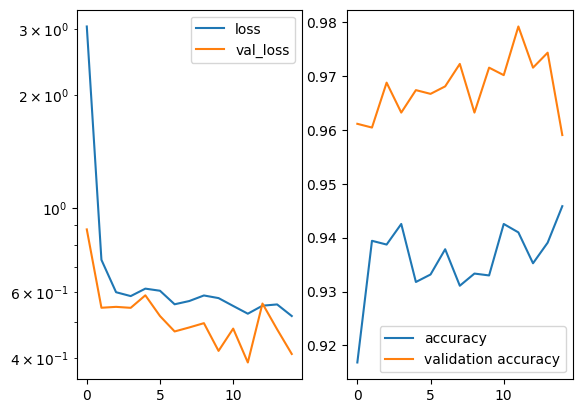

360/360 [==============================] - 8s 24ms/step - loss: 0.5173 - accuracy: 0.9458 - val_loss: 0.4101 - val_accuracy: 0.9590


In [ ]:
history=model.fit(X_train,y_train,batch_size=16,validation_split=0.2,epochs=15,callbacks=accuracy_loss_plot)

In [ ]:
### train performance

In [ ]:
y_pred = model.predict(X_train,batch_size=16)
y_pred = np.argmax(y_pred,axis=-1)
y_true = np.argmax(y_train,axis=-1)

450/450 [==============================] - 8s 17ms/step


              precision    recall  f1-score   support

           0       0.98      0.93      0.95      2415
           1       1.00      1.00      1.00      2399
           2       0.93      0.98      0.96      2386

    accuracy                           0.97      7200
   macro avg       0.97      0.97      0.97      7200
weighted avg       0.97      0.97      0.97      7200



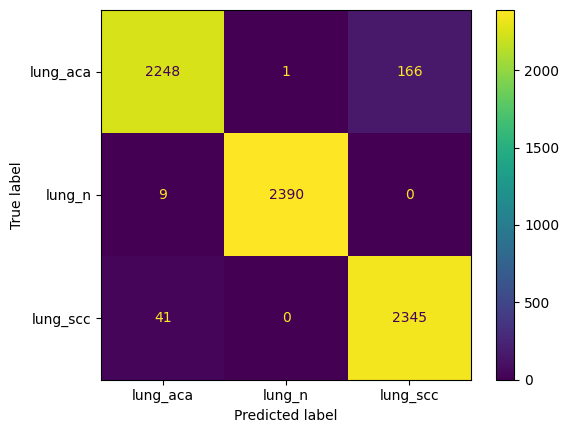

In [ ]:
# print # classification Report
print(classification_report(y_true,y_pred))
cm = confusion_matrix(y_true,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=list(le.classes_))
disp.plot()
plt.show()

In [ ]:
### test performace

In [ ]:
# get model predictions
y_pred = model.predict(X_test,batch_size=16)
y_pred = np.argmax(y_pred,axis=-1)
y_true = np.argmax(y_test,axis=-1)


113/113 [==============================] - 3s 20ms/step


              precision    recall  f1-score   support

           0       0.97      0.92      0.94       585
           1       1.00      0.99      1.00       601
           2       0.93      0.98      0.95       614

    accuracy                           0.96      1800
   macro avg       0.96      0.96      0.96      1800
weighted avg       0.96      0.96      0.96      1800



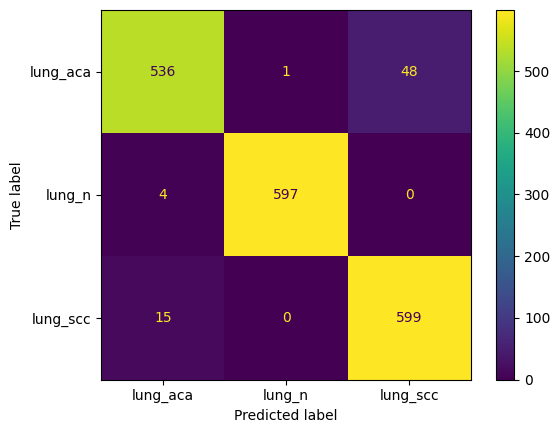

In [ ]:
# print # classification Report
print(classification_report(y_true,y_pred))
cm = confusion_matrix(y_true,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=list(le.classes_))
disp.plot()
plt.show()

In [ ]:
del(model)

### Vision Transformer B16

In [ ]:
vit_model = vit.vit_b16(
        image_size = 224,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 3)

vit_model.summary()

347502902/347502902 [==============================] - 1s 0us/step
Model: "vit-b16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 embedding (Conv2D)          (None, 14, 14, 768)       590592    
                                                                 
 reshape (Reshape)           (None, 196, 768)          0         
                                                                 
 class_token (ClassToken)    (None, 197, 768)          768       
                                                                 
 Transformer/posembed_input  (None, 197, 768)          151296    
  (AddPositionEmbs)                                              
                                                                 
 Transformer/encoderblock_0  ((None, 197, 768),        708

In [ ]:
model = tf.keras.Sequential([
        vit_model,
        Flatten(),
        BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
        Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
        Dropout(rate= 0.35, seed= 123),
    #Dense(128, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006), bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    #Dropout(rate= 0.45, seed= 123),
    Dense(3, activation= 'softmax')
    ],
    name = 'vision_transformer')

model.summary()

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 flatten_1 (Flatten)         (None, 768)               0         
                                                                 
 batch_normalization_3 (Bat  (None, 768)               3072      
 chNormalization)                                                
                                                                 
 dense_6 (Dense)             (None, 256)               196864    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 3)                 771       
                                                

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate= 0.001), metrics=['accuracy'])

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                 factor = 0.2,
                                                 patience = 2,
                                                 verbose = 1,
                                                 min_delta = 1e-4,
                                                 min_lr = 1e-6)

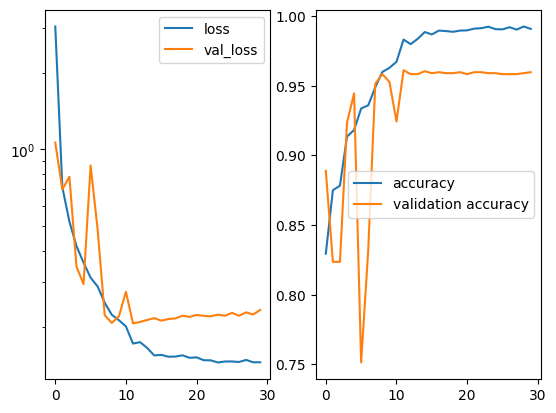

360/360 [==============================] - 81s 226ms/step - loss: 0.1454 - accuracy: 0.9908 - val_loss: 0.2335 - val_accuracy: 0.9597 - lr: 1.0000e-06


In [ ]:
history=model.fit(X_train,y_train,validation_split=0.2,epochs=30,batch_size=16, callbacks=[accuracy_loss_plot,reduce_lr])

In [ ]:
### Train Performance

In [ ]:
y_pred = model.predict(X_train,batch_size=16)
y_pred = np.argmax(y_pred,axis=-1)
y_true = np.argmax(y_train,axis=-1)

450/450 [==============================] - 31s 65ms/step


              precision    recall  f1-score   support

           0       0.99      0.98      0.98      2415
           1       1.00      1.00      1.00      2399
           2       0.98      0.99      0.98      2386

    accuracy                           0.99      7200
   macro avg       0.99      0.99      0.99      7200
weighted avg       0.99      0.99      0.99      7200



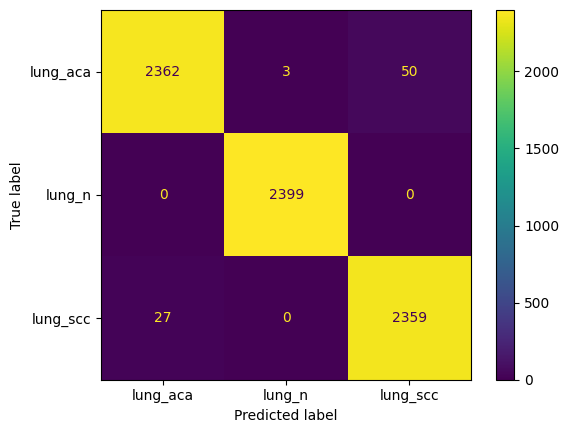

In [ ]:
# print # classification Report
print(classification_report(y_true,y_pred))
cm = confusion_matrix(y_true,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=list(le.classes_))
disp.plot()
plt.show()

In [ ]:
#### Test Performance

In [ ]:
# get model predictions
y_pred = model.predict(X_train,batch_size=16)
y_pred = np.argmax(y_pred,axis=-1)
y_true = np.argmax(y_train,axis=-1)


450/450 [==============================] - 29s 65ms/step


              precision    recall  f1-score   support

           0       0.99      0.98      0.98      2415
           1       1.00      1.00      1.00      2399
           2       0.98      0.99      0.98      2386

    accuracy                           0.99      7200
   macro avg       0.99      0.99      0.99      7200
weighted avg       0.99      0.99      0.99      7200



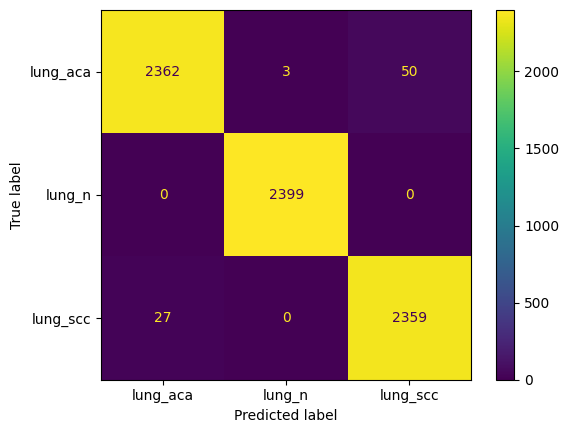

In [ ]:
# print # classification Report
print(classification_report(y_true,y_pred))
cm = confusion_matrix(y_true,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=list(le.classes_))
disp.plot()
plt.show()

#### Test Perfornmance

In [ ]:
# get model predictions
y_pred = model.predict(X_test,batch_size=16)
y_pred = np.argmax(y_pred,axis=-1)
y_true = np.argmax(y_test,axis=-1)

113/113 [==============================] - 12s 82ms/step


              precision    recall  f1-score   support

           0       0.94      0.90      0.92       585
           1       1.00      1.00      1.00       601
           2       0.91      0.94      0.92       614

    accuracy                           0.95      1800
   macro avg       0.95      0.95      0.95      1800
weighted avg       0.95      0.95      0.95      1800



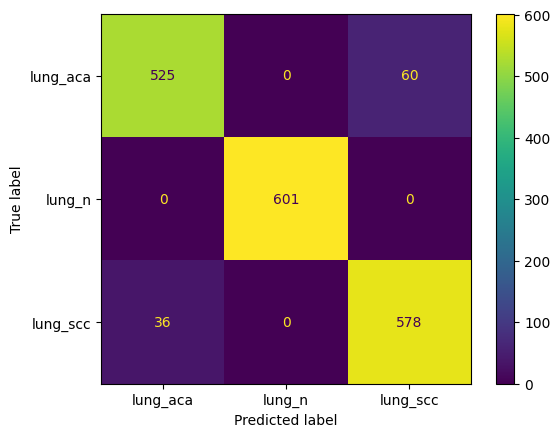

In [ ]:
# print # classification Report
print(classification_report(y_true,y_pred))
cm = confusion_matrix(y_true,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=list(le.classes_))
disp.plot()
plt.show()

In [ ]:
del(model)
del(vit_model)

### Vision Transformer B32

In [ ]:
vit_model = vit.vit_b32(
        image_size = 224,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 3)

353253686/353253686 [==============================] - 1s 0us/step


In [ ]:
vit_model.summary()

Model: "vit-b32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 embedding (Conv2D)          (None, 7, 7, 768)         2360064   
                                                                 
 reshape_1 (Reshape)         (None, 49, 768)           0         
                                                                 
 class_token (ClassToken)    (None, 50, 768)           768       
                                                                 
 Transformer/posembed_input  (None, 50, 768)           38400     
  (AddPositionEmbs)                                              
                                                                 
 Transformer/encoderblock_0  ((None, 50, 768),         7087872   
  (TransformerBlock)          (None, 12, None, None)       

In [ ]:
model = tf.keras.Sequential([
        vit_model,
        Flatten(),
        BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
        Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
        Dropout(rate= 0.35, seed= 123),
    #Dense(128, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006), bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    #Dropout(rate= 0.45, seed= 123),
    Dense(3, activation= 'softmax')
    ],
    name = 'vision_transformer')

model.summary()

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b32 (Functional)        (None, 768)               87455232  
                                                                 
 flatten_2 (Flatten)         (None, 768)               0         
                                                                 
 batch_normalization_4 (Bat  (None, 768)               3072      
 chNormalization)                                                
                                                                 
 dense_8 (Dense)             (None, 256)               196864    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 3)                 771       
                                                

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate= 0.001), metrics=['accuracy'])

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                 factor = 0.2,
                                                 patience = 2,
                                                 verbose = 1,
                                                 min_delta = 1e-4,
                                                 min_lr = 1e-6)

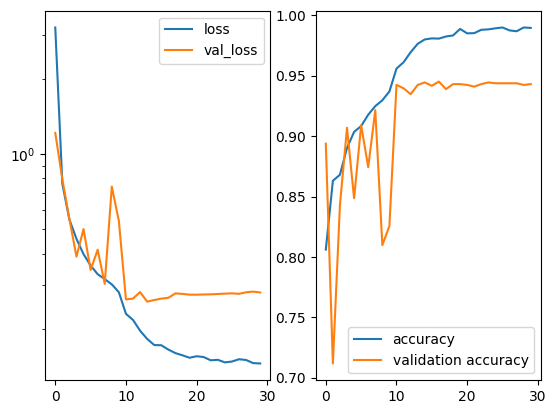

360/360 [==============================] - 26s 73ms/step - loss: 0.1456 - accuracy: 0.9896 - val_loss: 0.2799 - val_accuracy: 0.9431 - lr: 1.0000e-06


In [ ]:
history=model.fit(X_train,y_train,validation_split=0.2,epochs=30,batch_size=16, callbacks=[accuracy_loss_plot,reduce_lr])

In [ ]:
### Train Performance

In [ ]:
y_pred = model.predict(X_train,batch_size=16)
y_pred = np.argmax(y_pred,axis=-1)
y_true = np.argmax(y_train,axis=-1)

450/450 [==============================] - 10s 18ms/step


              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2415
           1       1.00      1.00      1.00      2399
           2       0.98      0.98      0.98      2386

    accuracy                           0.98      7200
   macro avg       0.98      0.98      0.98      7200
weighted avg       0.98      0.98      0.98      7200



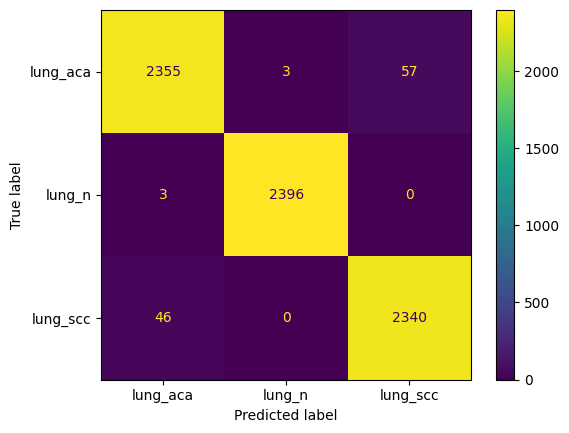

In [ ]:
# print # classification Report
print(classification_report(y_true,y_pred))
cm = confusion_matrix(y_true,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=list(le.classes_))
disp.plot()
plt.show()

In [ ]:
#### Test Perfornmance

In [ ]:
# get model predictions
y_pred = model.predict(X_test,batch_size=16)
y_pred = np.argmax(y_pred,axis=-1)
y_true = np.argmax(y_test,axis=-1)


113/113 [==============================] - 7s 35ms/step


              precision    recall  f1-score   support

           0       0.92      0.89      0.90       585
           1       0.99      0.99      0.99       601
           2       0.91      0.93      0.92       614

    accuracy                           0.94      1800
   macro avg       0.94      0.94      0.94      1800
weighted avg       0.94      0.94      0.94      1800



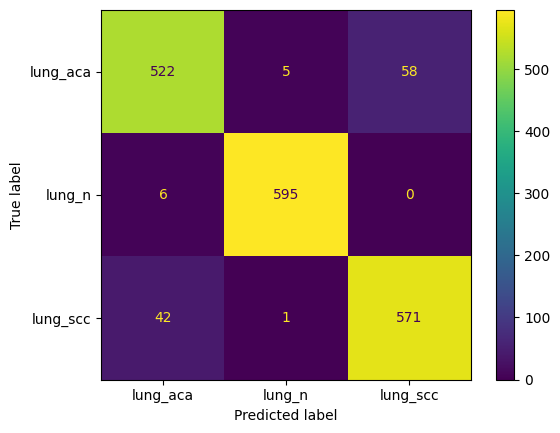

In [ ]:
# print # classification Report
print(classification_report(y_true,y_pred))
cm = confusion_matrix(y_true,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=list(le.classes_))
disp.plot()
plt.show()

In [ ]:
del(model)